This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data). The synthesis model is a CART.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import preprocessing

from scipy.stats import ks_2samp

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

Import the data.

In [3]:
# import standardized lat/long location data
train_data = pd.read_csv("Data/cleaned_ipums_data.csv")

***

In [4]:
train_data

,INCWAGE,years_of_educ,potential_experience,non_white,SEX
0,-0.579435,1.109071,-0.039398,0,1
1,0.564281,0.724424,0.369388,0,0
2,-0.748874,-0.044869,-1.347515,0,0
3,-0.935257,-0.814163,-1.511030,0,0
4,-0.164308,-0.429516,1.186962,1,0
...,...,...,...,...,...
197751,-0.092296,1.109071,-0.448185,0,0
197752,-0.854774,1.109071,-0.611699,0,1
197753,0.521921,1.777461,0.063806,0,0
197754,-0.981853,0.724424,-0.448185,0,1


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Function to be used in Bayesian bootstrap.

In [5]:
def stat(x):
    return x

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [6]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,['INCWAGE', 'years_of_educ', 'potential_experience']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['INCWAGE', 'years_of_educ', 'potential_experience']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)
    
    cart_non_white.fit(X=train_data.loc[:,['INCWAGE', 'years_of_educ', 'potential_experience']], y=train_data.loc[:,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data.loc[:,['INCWAGE', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data['non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['INCWAGE', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(bst_vals[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,['INCWAGE', 'years_of_educ', 'potential_experience', 'non_white']], y=train_data.loc[:,"SEX"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,['INCWAGE', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [train_data.SEX[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        bst_vals = [bayesian_bootstrap(X=np.array(x), 
                                       statistic=stat,
                                       n_replications=1,
                                       resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['INCWAGE', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(bst_vals[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "SEX"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs

In [7]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_non_white_, mb_sex_):

        pmse_ratios, _ = train_models(train_data=train_data,
                                      number_synthetic_datasets=number_synthetic_datasets,
                                      number_gmm_initializations=number_gmm_initializations,
                                      num_components_=int(num_components_),
                                      mb_non_white_=int(mb_non_white_),
                                      mb_sex_=int(mb_sex_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_non_white_": (10, 300.99),
            "mb_sex_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [8]:
nsd = 20
ngi = 5
# random_states = [np.random.RandomState(1234), , np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
random_states = [np.random.RandomState(1234)]

In [9]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   | mb_non... |  mb_sex_  | num_co... |
-------------------------------------------------------------
| 1         | -1.029    | 65.73     | 191.0     | 93.6      |
| 2         | -8.979    | 238.5     | 237.0     | 62.06     |
| 3         | -0.8527   | 90.45     | 243.3     | 193.0     |
| 4         | -0.2536   | 264.9     | 114.1     | 105.7     |
| 5         | -4.655    | 208.9     | 217.4     | 80.71     |
| 6         | -1.195    | 91.55     | 240.6     | 188.4     |
| 7         | -2.516    | 72.65     | 278.5     | 201.0     |
| 8         | -0.5576   | 262.9     | 85.65     | 118.4     |
| 9         | -0.7004   | 298.1     | 99.74     | 101.7     |
| 10        | -0.5608   | 258.3     | 90.4      | 74.51     |
| 11        | -0.6304   | 215.0     | 106.7     | 105.1     |
| 12        | -0.2245   | 242.7     | 126.3     | 156.1     |
| 13        | -0.1246   | 291.4     | 124.8     | 163.6     |
| 14        | -0.07803  | 266.6     | 98.82     | 201.0     |
| 15    

***

In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [12]:
run_targets

[array([1.02916286, 1.02916286, 0.85267948, 0.25362614, 0.25362614,
        0.25362614, 0.25362614, 0.25362614, 0.25362614, 0.25362614,
        0.25362614, 0.22451095, 0.12457188, 0.07802692, 0.07802692,
        0.07802692, 0.07802692, 0.07802692, 0.07802692, 0.07286234,
        0.07286234, 0.07286234, 0.07286234, 0.07286234, 0.07286234,
        0.07286234, 0.07286234, 0.07286234, 0.07286234, 0.07286234])]

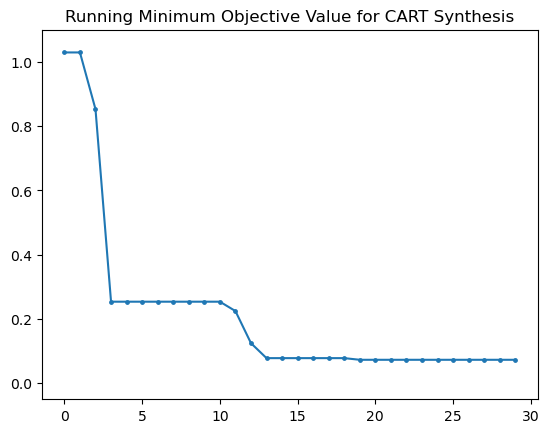

In [15]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets, s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.ylim(-0.05, 1.1)
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [16]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [18]:
best_params

{'target': -0.07286233853928617,
 'params': {'mb_non_white_': 261.70542263661434,
  'mb_sex_': 118.29018348782265,
  'num_components_': 179.3951023396654}}

***

Generate 20 synthetic datasets.

In [19]:
pmse_ratios, full_sXs = train_models(train_data=train_data,
                                     number_synthetic_datasets=20,
                                     # hyperparameters for GMM
                                     number_gmm_initializations=ngi,
                                     num_components_=int(best_params['params']['num_components_']),
                                     # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                     mb_sex_=int(best_params['params']['mb_sex_']),
                                     mb_non_white_=int(best_params['params']['mb_non_white_']))

In [20]:
np.mean(pmse_ratios)

1.6621647950378957

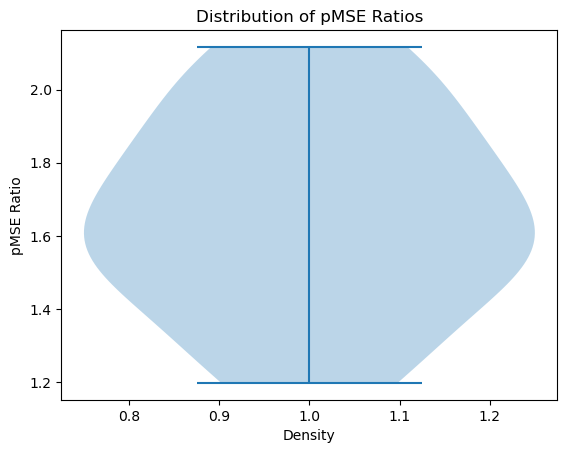

In [21]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [22]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/cart_optimizer_logistic_pmse_ipums_" + str(i) + ".csv", index=False)

***